In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib as mpl
from scipy.optimize import curve_fit as cf
from math import floor
import os
from scipy.signal import find_peaks as pk

In [2]:
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.markersize'] = 4
#mpl.rcParams['figure.autolayout'] = True
mpl.rcParams['font.size'] = 15
mpl.rcParams['errorbar.capsize'] = 3
mpl.rcParams['lines.markeredgewidth'] = 1
mpl.rcParams['axes.axisbelow'] = True

In [3]:
import os
os.environ['PINT_ARRAY_PROTOCOL_FALLBACK'] = "0"
import pint
ureg = pint.UnitRegistry()
Q_ = ureg.Quantity
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    Q_([])

In [4]:
lineal = lambda x,a,b : a*x+b

def r2(y,x,lineal,pars):
    r2 = 1 - (np.sum((y-lineal(x,*pars))**2)/np.sum((y-np.mean(y))**2))
    return r2

def chi2_red(y,y_err,x,func,popt):
    puntos = len(y)
    params = len(popt)
    grados_lib = puntos - params - 1
    y_ajuste = func(x,*popt)
    
    chi_cuadrado = np.sum(((y-y_ajuste)/y_err)**2)
    chi_reducido = chi_cuadrado/grados_lib
    return chi_reducido

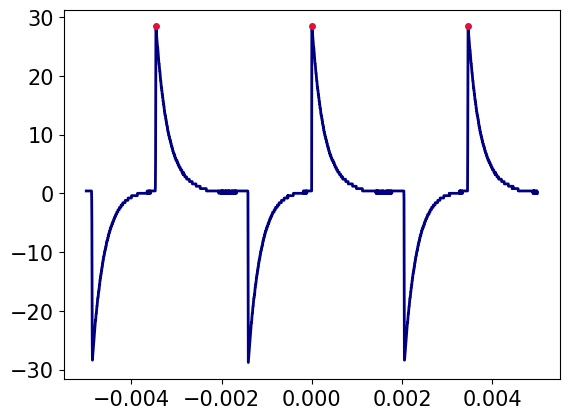

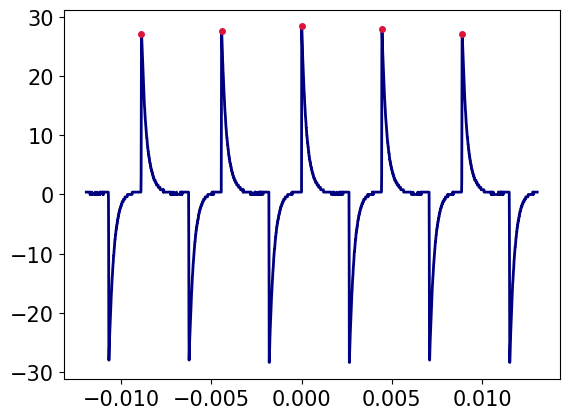

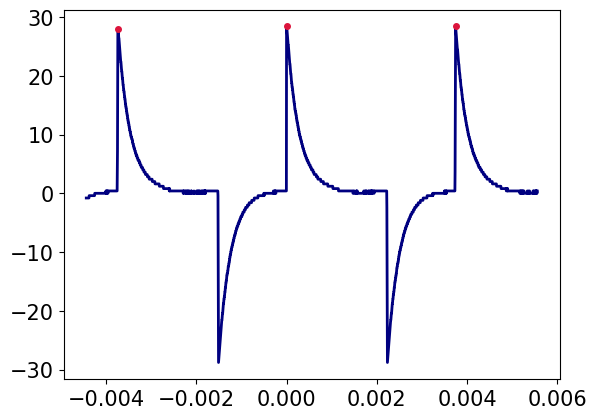

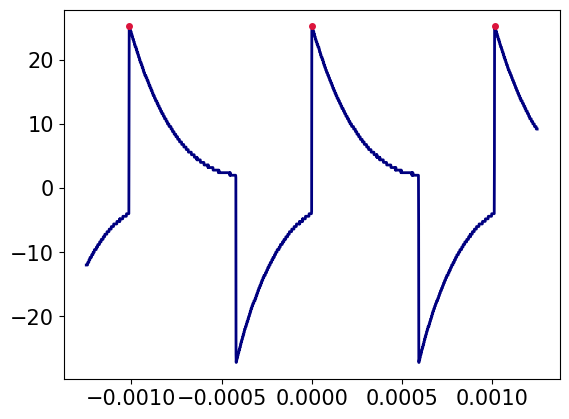

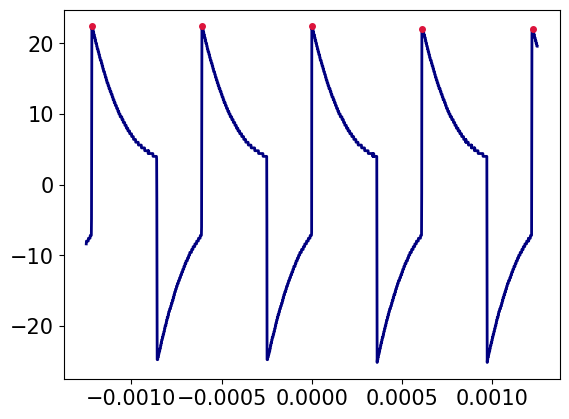

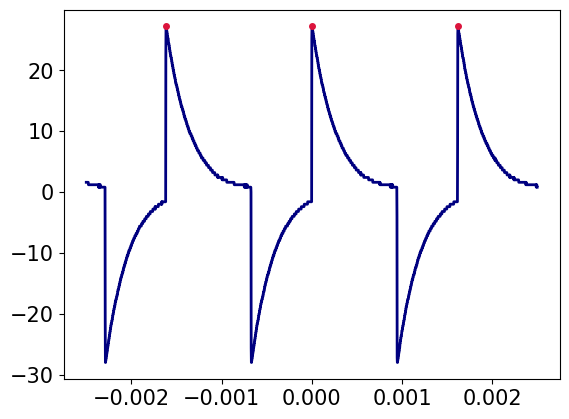

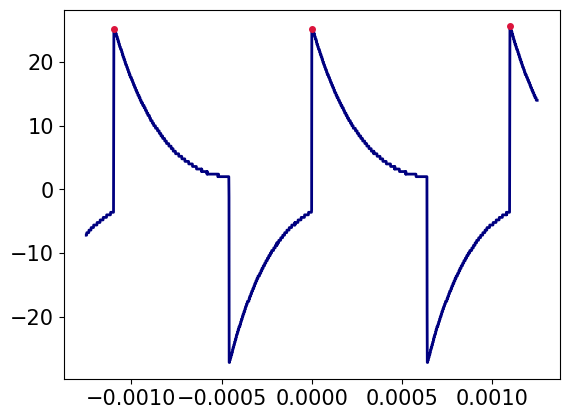

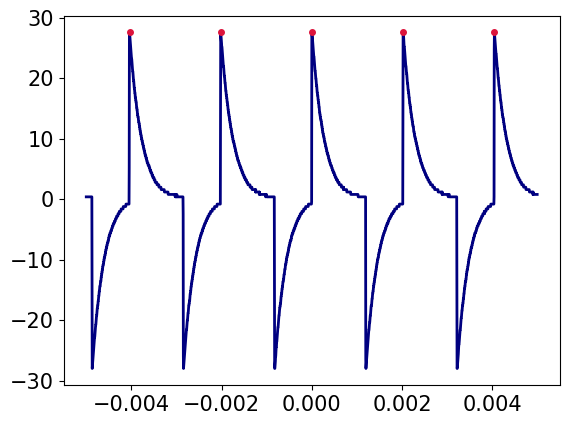

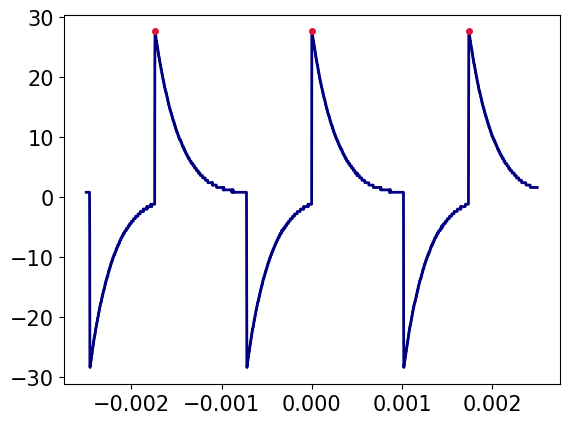

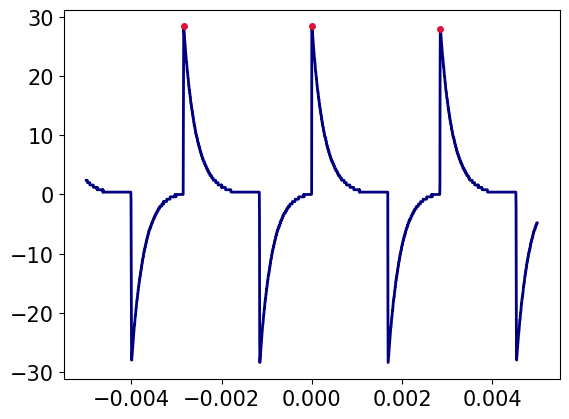

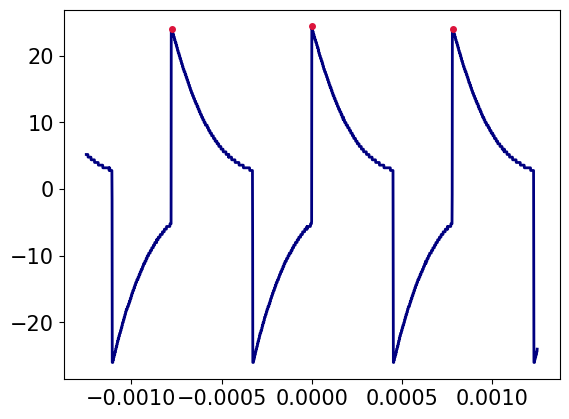

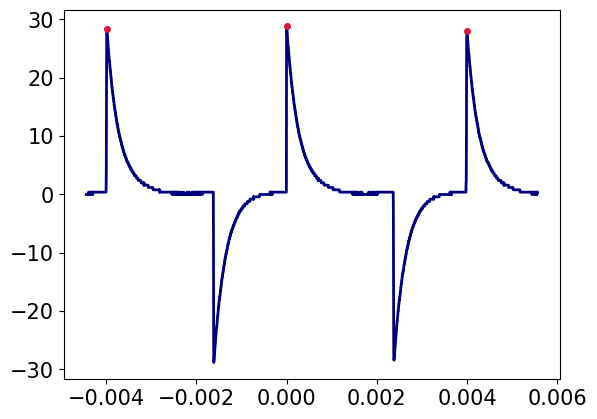

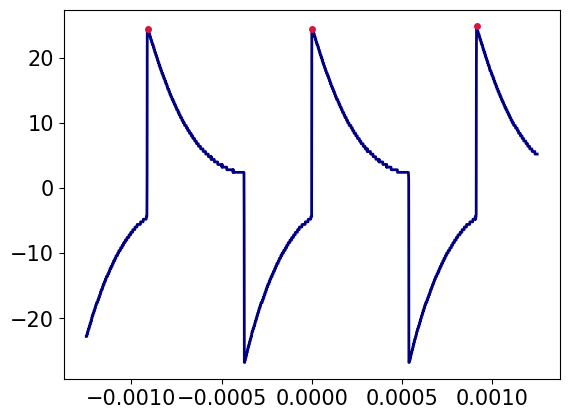

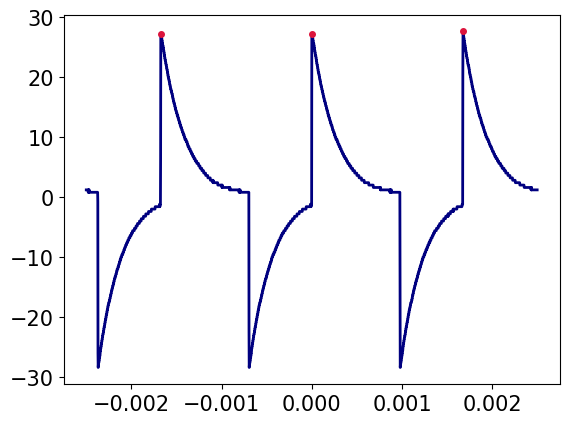

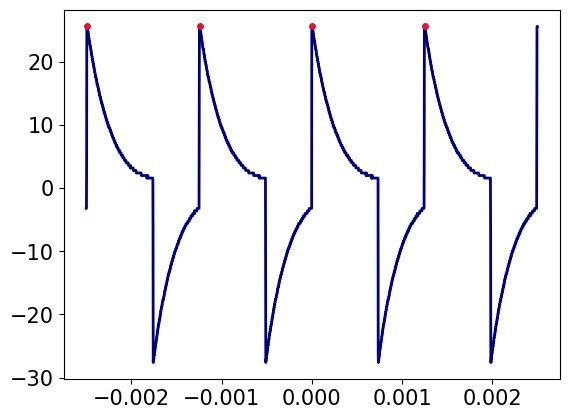

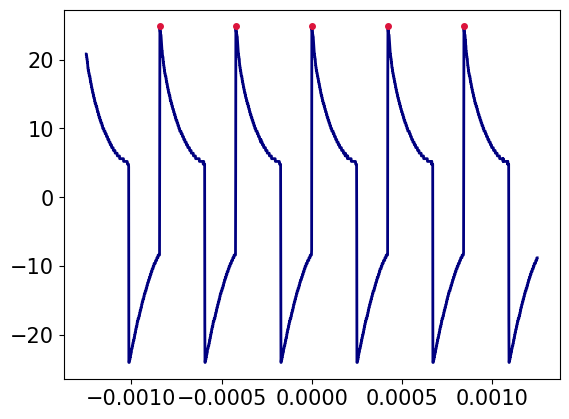

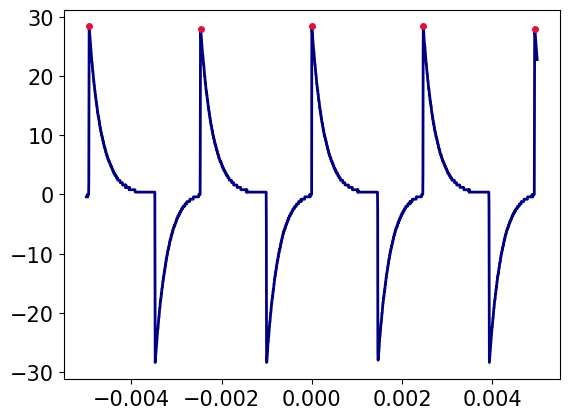

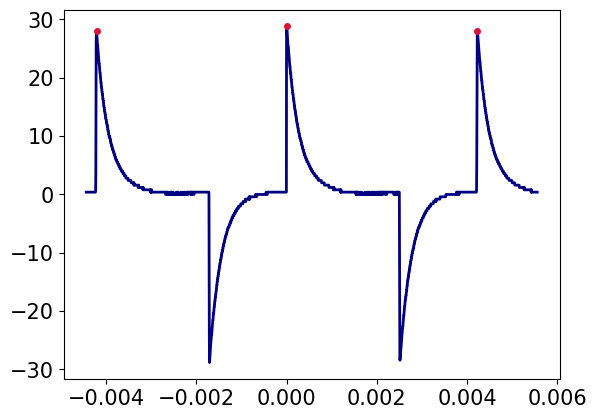

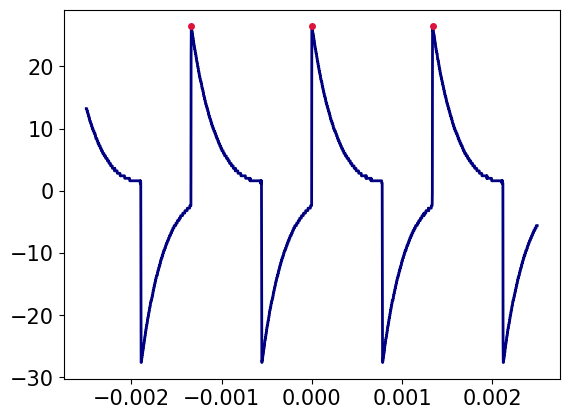

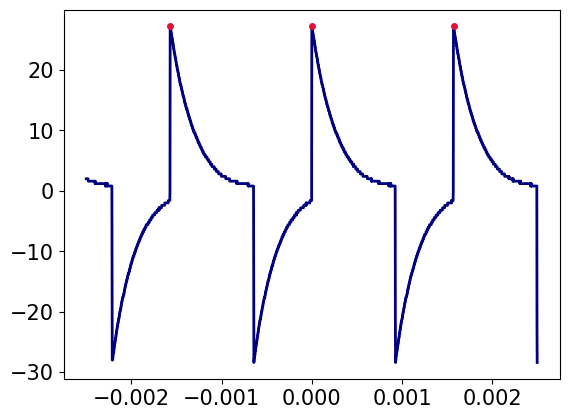

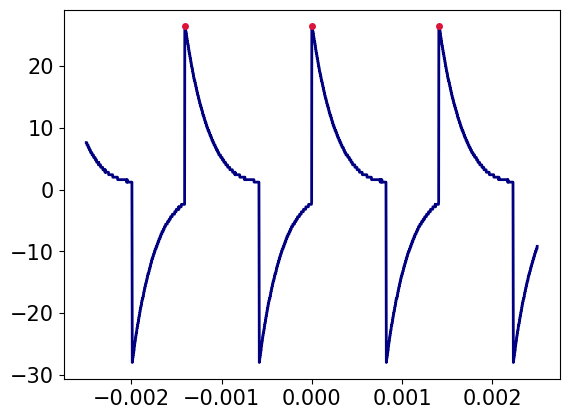

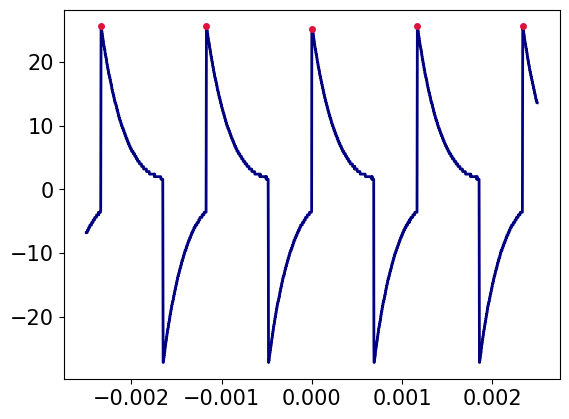

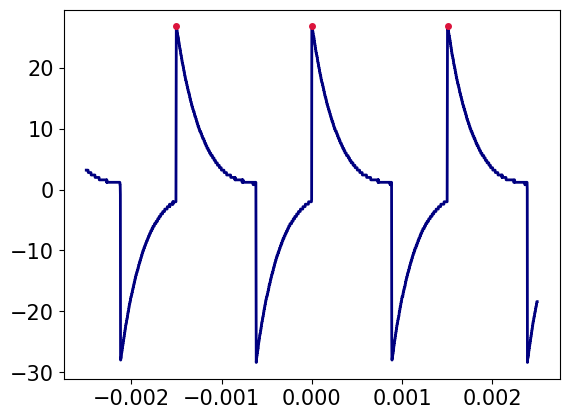

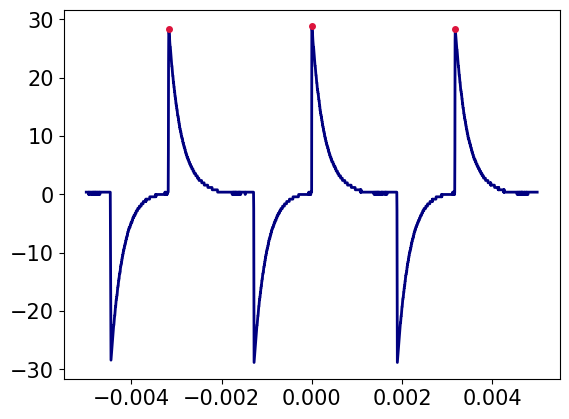

[ 289.01734104  225.09848059  267.23677178  987.16683119 1637.33115023
  618.04697157  912.40875912  494.55984174  575.04312823  351.37034434
 1284.52151574  250.62656642 1097.09270433  597.37156511  801.71031534
 2373.88724036  404.8582996   236.85457129  747.94315632  636.94267516
  710.22727273  855.79803166  665.33599468  315.05986137] [0.27270206 0.32033277 0.23314872 0.7953563  1.69484229 0.62352458
 0.67945314 0.61852026 0.53977336 0.40306104 1.34667682 0.20506655
 0.98235231 0.58250507 0.90860723 3.56267672 0.41449789 0.18314883
 0.91316193 0.66223375 0.82338946 0.92603799 0.72259117 0.324061  ]


In [5]:
files = os.listdir('special/barrido L')

names = []
for i in range(len(files)):
    if files[i].endswith('.csv'):
        names.append(int(files[i][:-4]))
names = np.array(names)

periods = []
err_periods = []
for name in names:
    df = pd.read_csv(f'special/barrido L/{name}.csv')
    err_t = (df.t[2499]-df.t[0])/len(df.t)
    
    pk_idx = pk(df.V_R,height=max(df.V_R)-5,distance=100)[0]
    n = len(pk_idx)
    
    periods.append(np.mean(np.diff(df.t[pk_idx])))
    err_periods.append(np.sqrt(2/n)*err_t)
    
    plt.scatter(df.t[pk_idx],df.V_R[pk_idx],c='crimson',zorder=2)
    plt.plot(df.t,df.V_R,'navy',zorder=1)
    plt.show()
periods = np.array(periods)
err_periods = np.array(err_periods)
freqs = 1/periods
err_freqs = err_periods/periods**2
print(freqs,err_freqs)

In [23]:
err_L = names*(0.01+np.random.normal(0.0025,0.0025,len(names)))
err_log_freqs = err_freqs/freqs
err_log_L = err_L/names

-1.9836190969477194 17.625058625333157
0.9994103771179593
5.826195475664974


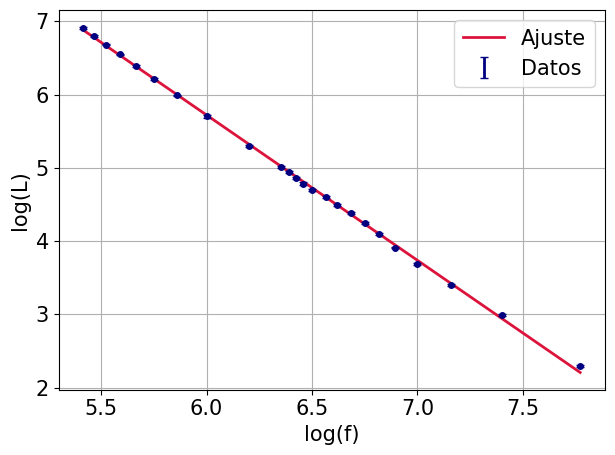

In [44]:
pars,cov = cf(lineal,np.log(freqs),np.log(names),sigma=err_log_L,absolute_sigma=True)
a,b = pars
err_a = cov[0,0]
err_b = cov[1,1]
x_adj = np.linspace(min(np.log(freqs)),max(np.log(freqs)))
y_adj = lineal(x_adj,*pars)
plt.scatter(np.log(freqs),np.log(names),c='navy',zorder=3)
plt.errorbar(np.log(freqs),np.log(names),yerr=err_log_L,fmt='None',ecolor='Navy',zorder=2,label='Datos')
plt.plot(x_adj,y_adj,'crimson',zorder=1,label='Ajuste')
plt.grid()
plt.xlabel('log(f)')
plt.ylabel('log(L)')
plt.legend()
plt.tight_layout()
plt.savefig('plots/lineal.png',bbox_inches='tight')

print(a,b)
print(r2(np.log(names),np.log(freqs),lineal,pars))
print(chi2_red(np.log(names),err_log_L,np.log(freqs),lineal,pars))

def inductance(f,a,b):
    return np.exp(b)*f**a

def err_inductance(f,a,b,err_f,err_a,err_b):
    return np.exp(b)*f**a * np.sqrt(err_b**2+a**2/f**2*err_f**2+np.log(abs(a))**2*err_a**2)

def omega(L,a,b):
    return np.exp(-b/a)*L**(1/a)

5.663495049694516


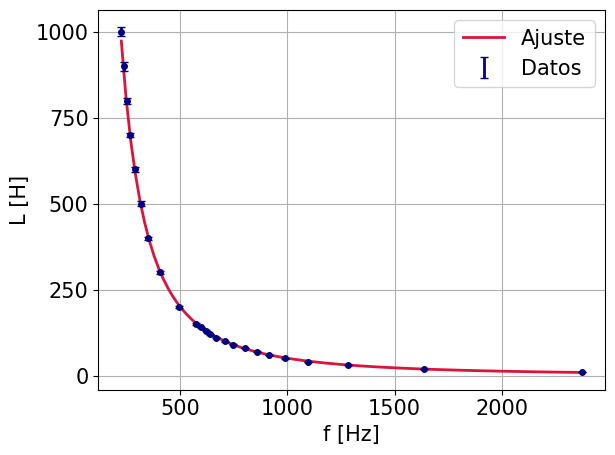

In [32]:
my_L = np.linspace(min(names),max(names),100)
my_w = np.linspace(min(freqs),max(freqs),100)

print(chi2_red(names,err_L,freqs,inductance,pars))

plt.scatter(freqs,names,c='navy',zorder=3)
plt.errorbar(freqs,names,yerr=err_L,fmt='None',ecolor='Navy',zorder=2,label='Datos')
plt.plot(my_w,inductance(my_w,a,b),'crimson',zorder=1,label='Ajuste')
plt.grid()
plt.xlabel('f [Hz]')
plt.ylabel('L [H]')
plt.locator_params(axis='y',nbins=5)
plt.legend()
plt.tight_layout()
plt.savefig('plots/normal.png',bbox_inches='tight')
plt.show()

In [38]:
def L_from_signal(name,folder,a,b,err_a,err_b,plot=False):
    df = pd.read_csv(f'special/{folder}/{name}.csv')
    
    pk_idx = pk(df.V_R,height=max(df.V_R)-5,distance=100)[0]
    
    period = np.mean(np.diff(df.t[pk_idx]))
    freq = 1/period

    err_t = (df.t[2499]-df.t[0])/len(df.t)
    err_period = np.sqrt(2/n)*err_t
    err_freq = err_period/period**2

    L = inductance(freq,a,b)
    err_L = err_inductance(freq,a,b,err_freq,err_a,err_b)
    
    if plot:
        plt.scatter(df.t[pk_idx],df.V_R[pk_idx],c='crimson',zorder=2)
        plt.plot(df.t,df.V_R,'navy',zorder=1)
        plt.show()
    
    return L,err_L

def L_volume(L_aire,L_m,V,V_x):
    Lx = V/V_x * (L_m-L_aire) + L_aire
    return Lx

In [43]:
aire_1600,err_aire_1600 =  L_from_signal('aire','1600',a,b,err_a,err_b)
aire_larga,err_aire_larga =  L_from_signal('aire','larga',a,b,err_a,err_b)
for material in ['aluminio','bronce','cobre','laton','niquel','hierro 1','hierro 2','hierro 3','hierro fino']:
    print(f'{material}: {np.round(L_from_signal(material,"1600",a,b,err_a,err_b)[0]/aire_1600,2)}, {np.round(L_from_signal(material,"larga",a,b,err_a,err_b)[0]/aire_larga,2)}')

aluminio: 0.92, 0.94
bronce: 0.95, 0.96
cobre: 0.92, 0.95
laton: 0.98, 0.98
niquel: 1.16, 1.31
hierro 1: 1.95, 2.52
hierro 2: 2.7, 4.87
hierro 3: 3.5, 5.99
hierro fino: 1.7, 2.05


(0.28, 0.36)

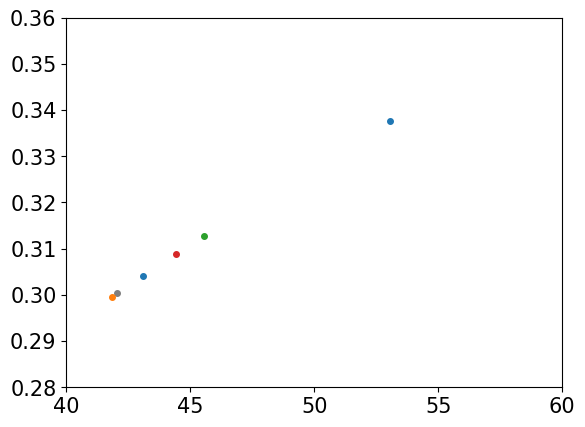

In [70]:
files_prueba = os.listdir('special/1600')
snoopy = []
for archivo in files_prueba:
    snoopy.append(L_from_signal(archivo[:-4],'1600',a,b,err_a,err_b))

snoopy = snoopy[:9] + snoopy[10:]

for element in snoopy:
    plt.scatter(element[0],element[1])
plt.xlim(40,60)
plt.ylim(0.28,0.36)